## A Face Detection Pipeline

As we all know, real world datasets are very noisy and heterogeneous, and may have missing features, and the data may not be clean so that it can directly be used to train a Machine Learning Model. Instead, data needs to be cleaned and made in a form so that it can be consumed by a down-stream model. We also might need to extract some features from the data.

One interesting and compelling application of machine learning is to images. In the real world, data is rarely so uniform and simple pixels will not be suitable and hence we need a way to extract features from these images. One such feature extraction technique is **Histogram of Oriented Gradients (HOG)**, which transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination.

**The goal of this notebook/project is to develop a simple face detection pipeline and train a SVM Model to detect faces in images.**

#### Standard Imports

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from skimage import data, color, feature, transform
from sklearn.feature_extraction.image import PatchExtractor
import skimage.data
import sklearn
from sklearn.datasets import fetch_lfw_people
from itertools import chain
import warnings
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings(action = 'ignore')

## What is HOG?

HOG (Histogram of Oriented Gradients) is a feature extraction method originally designed for pedestrian detection in images. The process involves:

1. Optional image pre-normalization to reduce illumination effects.
2. Application of horizontal and vertical gradient filters to capture edges, contours, and textures.
3. Division of the image into cells, with gradient orientation histograms computed for each.
4. Histogram normalization using neighboring cell blocks to further mitigate illumination variations.
5. Creation of a 1D feature vector from the cell data.

**The HOG feature extractor is built into the Scikit-Learn package, and that is what we are going to use to extract features from these images. Lets quickly visualize the HOG features.**

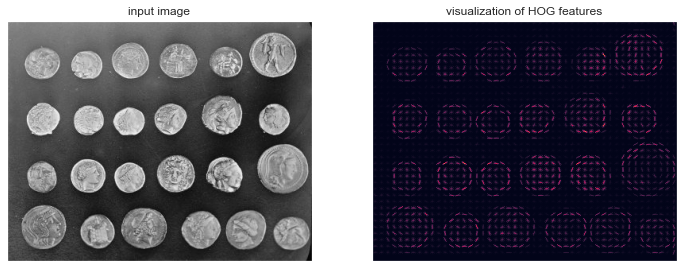

In [9]:
#reading an image from skimage package
image = color.rgb2gray(data.coins())
hog_vec, hog_vis = feature.hog(image, visualize=True)

#plotting the features extracted
fig, ax = plt.subplots(1, 2, figsize=(12, 6),subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

As we can see from the visualization above, the HOG features successfully capture edges, contours, and textures

#### Face Detector using HOG features

Using these HOG features, we can build up a simple facial detection algorithm with any Scikit-Learn estimator and just to keep it simple, I am using the SVM algorithm. Here are the next steps that I am going to follow:

1. Obtain a set of image thumbnails of faces to constitute "positive" training samples
2. Obtain a set of image thumbnails of non-faces to constitute "negative" training samples
3. Extract HOG features from these images
4. Train a SVC (Support Vector Classifier)
5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not
6. If detections overlap, combine them into a single window

##### 1. Obtain a set of image thumbnails of faces to constitute "positive" training samples

For some positive training samples that show a variety of faces, we have one easy set of data to work with—the Labeled Faces in the Wild dataset, which can be downloaded by Scikit-Learn. This gives us a sample of 13,000 face images to use for training.

In [14]:
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

##### 2. Obtain a set of negative training samples

Now, we need a set of training images that do not contain faces in them. One way to do this is to take any corpus of input images, and extract thumbnails from them at a variety of scales. Here we can use some of the images shipped with Scikit-Image, along with Scikit-Learn's `PatchExtractor`

In [16]:
imgs_to_use = ['camera', 'text', 'coins', 'moon','page', 'clock', 
               'immunohistochemistry','chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]

In [18]:
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

In [20]:
negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

In [21]:
negative_patches.shape

(30000, 62, 47)

This gives us 30000 images that do not contain faces in them. Visualizing them would give us a better idea of what they look like. Clearly, this does not have any faces in them and would work perfectly as negative images for training the SVC.

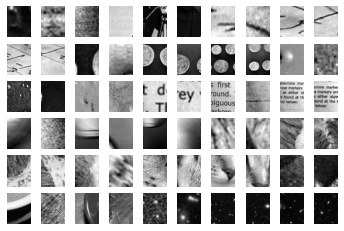

In [23]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

##### 3. Combine both the positive and negative images and extracting HOG features from these images

Now that we have these positive samples and negative samples, we can combine them and compute HOG features.

In [26]:
X_train = np.array([feature.hog(im) for im in chain(positive_patches,negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [27]:
X_train.shape, y_train.shape

((43233, 1215), (43233,))

This gives us 43233 images with 1215 features which we can pass to the SVC to train a model to detect faces from images.

##### 4. Training a SVC (Support Vector Classifier)

For such a high-dimensional binary classification task, a Linear support vector machine is a good choice. But, before training a SVC, we will need a baseline to measure the performance of the Support Vector Machine. For this, we can use a GaussianNB to get a baseline performance.

In [34]:
cross_val_score(GaussianNB(), X_train, y_train)

array([0.94726495, 0.97131953, 0.97189777, 0.97478603, 0.97455471])

As we can see, even a simple GaussianNB model can get us 95% accuracy. Now, let's train a SVC with GrisSearch over a few choices of `C`:

In [37]:
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.9887122973043431

In [38]:
grid.best_params_

{'C': 1.0}

In [39]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC()

As we can see, the LinearSVC model performs slightly better than the baseline. Now, lets test the model on some new images

##### 5. Finding faces in new images

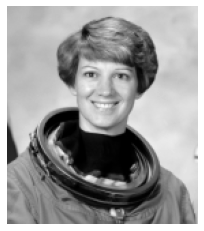

In [40]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

Next, we need to create a window function that iterates over patches of this image, and compute HOG features for each patch:

In [41]:
def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [42]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

Finally, we can take these HOG-featured patches and use our model to evaluate whether each patch contains a face:

In [43]:
labels = model.predict(patches_hog)
labels.sum()

50.0

We see that out of nearly 1900 patches, we have found 50 detections. Let's use the information we have about these patches to show where they lie on our test image, drawing them as rectangles:

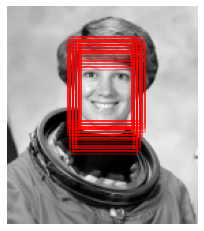

In [44]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))

## Future work, Improvements and Drawbacks:

1. training set, especially for negative features, is not very complete
2. current pipeline searches only at one scale, algorithm will miss faces that are not approximately 62×47 pixels. This can be straightforwardly addressed by using sliding windows of a variety of sizes, and re-sizing each patch using skimage.transform.resize before feeding it into the model
3. combine overlapped detection patches, for a production-ready pipeline, we would prefer not to have 30 detections of the same face, but to somehow reduce overlapping groups of detections down to a single detection

That was all for now, thank you for reading